# Notebook to ensemble the models trained on each site

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
from aidhs.paths import DATA_PATH, SITE_CODES

Setting DATA_PATH to /home/mathilde/Documents/projects/surHippo/processes/231002_new_patients_pipeline
Setting BASE_PATH to /home/mathilde/Documents/projects/surHippo/processes/231002_new_patients_pipeline/output/preprocessed_surf_data
Setting EXPERIMENT_PATH to /home/mathilde/Documents/projects/surHippo/processes/231002_new_patients_pipeline/models
Setting PARAMS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231002_new_patients_pipeline/params
Setting FS_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231002_new_patients_pipeline/output/fs_outputs
Setting HIPPUNFOLD_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231002_new_patients_pipeline/output/hippunfold_outputs
Setting BIDS_SUBJECTS_PATH to /home/mathilde/Documents/projects/surHippo/processes/231002_new_patients_pipeline/output/bids_outputs


In [2]:
features = [ 
    '.inter_z.asym.combat.label-avg.curvature.sm1',
    '.inter_z.asym.combat.label-avg.gauss-curv_filtered_sm1',
    '.inter_z.asym.combat.label-avg.gyrification.sm1',
    '.inter_z.asym.combat.label-avg.thickness.sm1',
    '.inter_z.asym.combat.label-avg.hippunfold_volume_icvcorr',
    ]

features_title = {
                '.gauss-curv_filtered': 'intrinsic curvature ',
                '.gyrification' : 'gyrification ',
                '.curvature' : 'mean curvature',
                '.thickness' : 'thickness ',
                '.hippunfold_volume' :'volume',
    }
def return_features_title(feature, features_title):
    for feat in set(features_title):
        if feat in feature:
            return features_title[feat]

filename_model = os.path.join(DATA_PATH, 'models', 'model_LogReg_Hippunfold features_{}.sav')

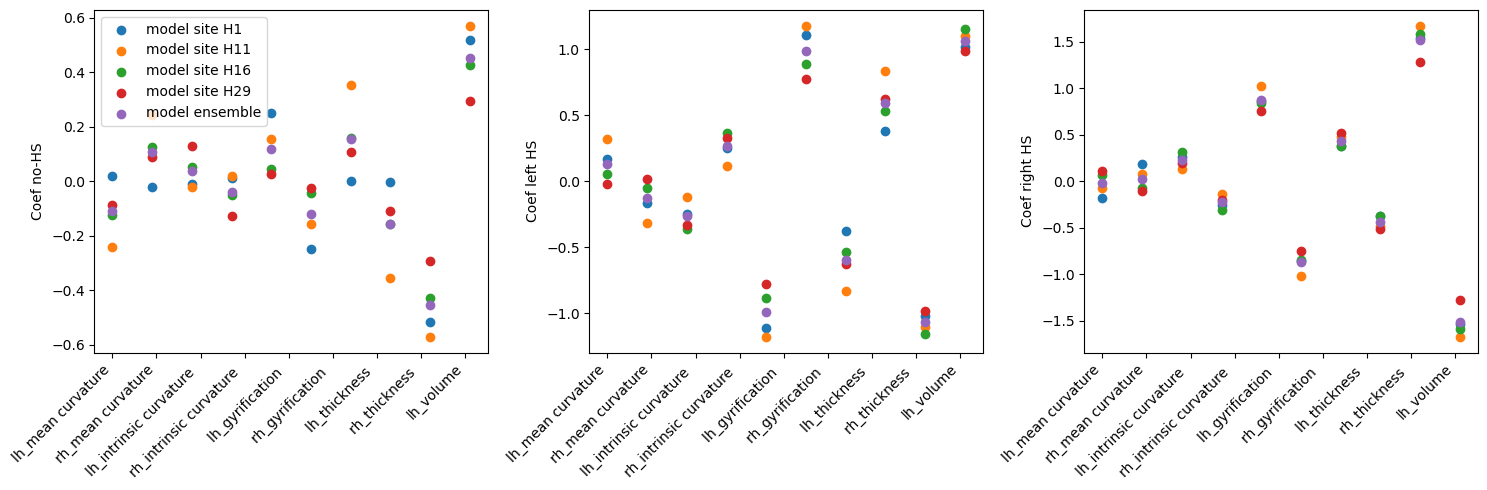

In [29]:
from aidhs.train_evaluate import  ModelLogR
from sklearn.pipeline import make_pipeline

sites = SITE_CODES

features_names = features
features_names = [['lh_'+return_features_title(feat, features_title), 'rh_'+return_features_title(feat, features_title)] for feat in features_names]
features_names = np.array(features_names).flatten()

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
models = []
for site in sites:
    # load model
    loaded_model = joblib.load(open(filename_model.format(site), 'rb'))
    models.append(loaded_model)
    # plot parameters
    ax1.scatter(features_names, loaded_model.steps[2][1].coef_[0,:], label=f'model site {site}')
    ax2.scatter(features_names, loaded_model.steps[2][1].coef_[1,:], label=f'model site {site}')
    ax3.scatter(features_names, loaded_model.steps[2][1].coef_[2,:], label=f'model site {site}')
    ax1.xaxis.set_ticks(np.linspace(0,10,10))
    ax2.xaxis.set_ticks(np.linspace(0,10,10))
    ax3.xaxis.set_ticks(np.linspace(0,10,10))
    ax1.set_xticklabels(features_names, rotation=45, ha='right')
    ax2.set_xticklabels(features_names, rotation=45, ha='right')
    ax3.set_xticklabels(features_names, rotation=45, ha='right')
    ax1.set_ylabel('Coef no-HS')
    ax2.set_ylabel('Coef left HS')
    ax3.set_ylabel('Coef right HS')
# create new model and save
ensemble_model = ModelLogR(seed_model=0)
ensemble_model_pipeline = ensemble_model.initialise_model()
ensemble_model_pipeline = make_pipeline(ensemble_model.imputer, ensemble_model.scalor, ensemble_model_pipeline)
#average parameters imputer
ensemble_model_pipeline.steps[0][1].statistics_ = np.mean([model.steps[0][1].statistics_ for model in models], axis=0)
#average parameters scalor
ensemble_model_pipeline.steps[1][1].scale_ = np.mean([model.steps[1][1].scale_ for model in models], axis=0)
ensemble_model_pipeline.steps[1][1].mean_ = np.mean([model.steps[1][1].mean_ for model in models], axis=0)
ensemble_model_pipeline.steps[1][1].var_ = np.mean([model.steps[1][1].var_ for model in models], axis=0)
#average parameters models
ensemble_model_pipeline.steps[2][1].coef_ = np.mean([model.steps[2][1].coef_ for model in models], axis=0)
ensemble_model_pipeline.steps[2][1].intercept_ = np.mean([model.steps[2][1].intercept_ for model in models], axis=0)
#save average pipeline
joblib.dump(ensemble_model_pipeline, filename_model.format('ensemble'))

#plot
ax1.scatter(features_names, ensemble_model_pipeline.steps[2][1].coef_[0,:], label=f'model ensemble')
ax2.scatter(features_names, ensemble_model_pipeline.steps[2][1].coef_[1,:], label=f'model ensemble')
ax3.scatter(features_names, ensemble_model_pipeline.steps[2][1].coef_[2,:], label=f'model ensemble')


ax1.legend()
plt.tight_layout()

# train model on all cohort to create model for new subject

In [31]:
import os
import pandas as pd
import numpy as np
from aidhs.train_evaluate import  ModelLogR, cross_validation_training, prepare_train_test_data
from aidhs.paths import BASE_PATH

In [38]:
#load or save matrix
output_path=os.path.join(BASE_PATH,'data_saved')
file = os.path.join(output_path,'matrix_norm_avg_230920.csv')   
# df.to_csv(file)
df=pd.read_csv(file, header=0,encoding='unicode_escape', index_col=0)

In [39]:
filename_model = os.path.join(DATA_PATH, 'models', 'model_LogReg_Hippunfold features_trainwhole.sav')

#initialise the sites and dataset to use
sites=['H11', 'H16', 'H1','H29']
file_split = os.path.join(BASE_PATH, 'dataset_C-P-DC_alltrain.csv') 

#initialise the model
model = ModelLogR(seed_model=0)
ensemble_model = model.initialise_model() 
ensemble_model_pipeline= make_pipeline(model.imputer, model.scalor, ensemble_model)

#preparation of the train and test data
train_dataset= prepare_train_test_data(df,  file_split, features, mode='train',)
X = train_dataset['X']
Y = train_dataset['Y']

#train on the fold
ensemble_model_pipeline.fit(X, Y)

#save classifiers
for i in range(0,len(sites)):
    joblib.dump(ensemble_model_pipeline, filename_model) 

Classes = ['control' 'lh_ipsi' 'rh_ipsi']
There is 363 subject for training
number ipsi lh: 81
number ipsi rh: 71
number control: 211


# compare models

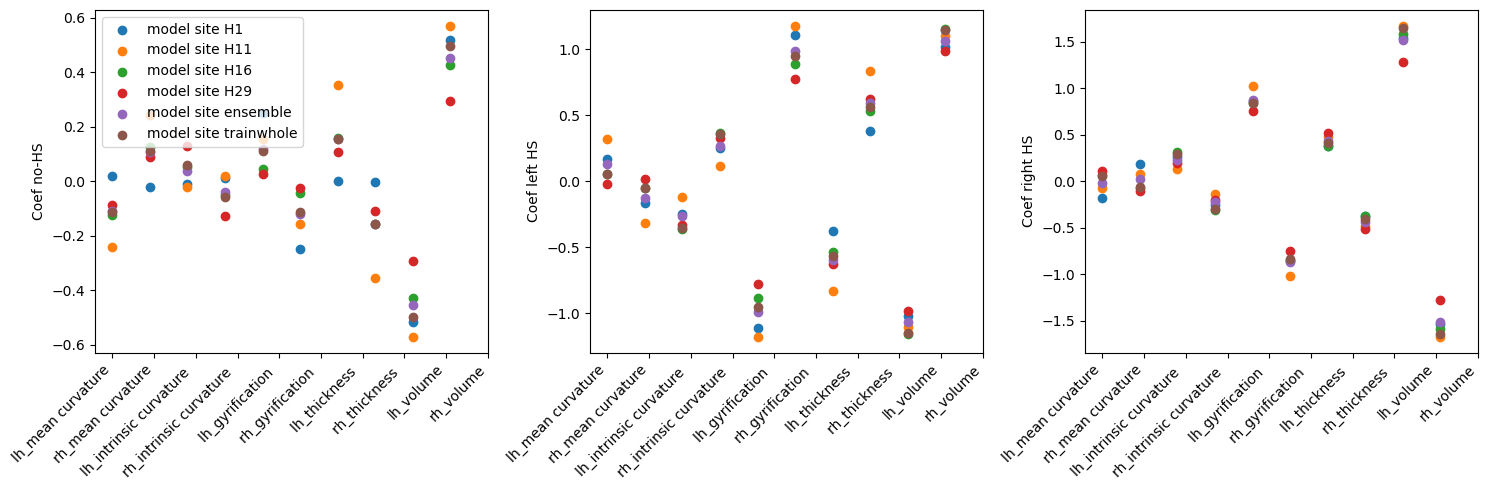

In [40]:
from aidhs.train_evaluate import  ModelLogR
from sklearn.pipeline import make_pipeline

filename_model = os.path.join(DATA_PATH, 'models', 'model_LogReg_Hippunfold features_{}.sav')
sites = ['H1','H11','H16','H29', 'ensemble', 'trainwhole']

features_names = features
features_names = [['lh_'+return_features_title(feat, features_title), 'rh_'+return_features_title(feat, features_title)] for feat in features_names]
features_names = np.array(features_names).flatten()

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))
for site in sites:
    # load model
    loaded_model = joblib.load(open(filename_model.format(site), 'rb'))
    # plot parameters
    ax1.scatter(features_names, loaded_model.steps[2][1].coef_[0,:], label=f'model site {site}')
    ax2.scatter(features_names, loaded_model.steps[2][1].coef_[1,:], label=f'model site {site}')
    ax3.scatter(features_names, loaded_model.steps[2][1].coef_[2,:], label=f'model site {site}')
    ax1.xaxis.set_ticks(np.linspace(0,10,10))
    ax2.xaxis.set_ticks(np.linspace(0,10,10))
    ax3.xaxis.set_ticks(np.linspace(0,10,10))
    ax1.set_xticklabels(features_names, rotation=45, ha='right')
    ax2.set_xticklabels(features_names, rotation=45, ha='right')
    ax3.set_xticklabels(features_names, rotation=45, ha='right')
    ax1.set_ylabel('Coef no-HS')
    ax2.set_ylabel('Coef left HS')
    ax3.set_ylabel('Coef right HS')


ax1.legend()
plt.tight_layout()